In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [28]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [29]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [30]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [31]:
selected_columns = [
    "cases",
    "week",
    "geocode",
    "cases_per_100k",
    "vim",
    "week_sin",
    "week_cos",
    "month_sin",
    "month_cos",
    "temp_avg",
    "humidity_avg",
    "precipitation_avg_ordinary_kriging",
]

df = df[selected_columns]

In [32]:
# Define outbreak categories based on cases_per_100k thresholds
bins = [0, 100, 200, 250, float('inf')]
labels = ['No', 'Moderate', 'High', 'Severe']

# Create the 'outbreak' column
df['outbreak'] = pd.cut(df['cases_per_100k'], bins=bins, labels=labels, right=False)

In [33]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='geocode', target_col='cases', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each geocode
weather_columns = ['precipitation_avg_ordinary_kriging']
data = create_lags(data, group_col='geocode', target_col=weather_columns, lags=[3, 4])

# data = create_lags(data, group_col='geocode', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='geocode', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [34]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['cases_per_100k', 'temp_avg', 'humidity_avg', "precipitation_avg_ordinary_kriging"]
lagged_vars = [col for col in data.columns if '_lag' in col]

# Filter scaler_vars to only include variables that are in data.columns
scaler_vars = [col for col in continuous_vars + lagged_vars if col in data.columns]

# remove weather columns from scaler_vars
scaler_vars.remove('precipitation_avg_ordinary_kriging')

In [35]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 201853)]
test_data = data[(data['week'] > 201853)]

columns_exclude = ['cases', 'precipitation_avg_ordinary_kriging', 'outbreak']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['outbreak']

X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['outbreak']

X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])

# Convert categorical target variable to numerical labels
y_train = y_train.astype('category').cat.codes  # No=0, Mild=1, Moderate=2, High=3
y_test = y_test.astype('category').cat.codes

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7404\1995730024.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.04868013  0.06015423  0.05250483 ... -0.05841145 -0.06606085
 -0.06223615]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7404\1995730024.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.06606085 -0.05458675 -0.05841145 ... -0.08518435 -0.08900905
 -0.08135965]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [36]:
X_train = X_train.copy()
X_test = X_test.copy()

# Properly convert geocode to category
X_train['geocode'] = X_train['geocode'].astype(str).astype('category')
X_test['geocode'] = X_test['geocode'].astype(str).astype('category')

# Create LGBM dataset and explicitly declare 'geocode' as categorical
train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=['geocode'])
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [37]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Step 7: Define LightGBM parameters for classification
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_class': 5,  # Four outbreak categories
    'verbose': -1
}

# Step 8: Train the model with early stopping
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions
probs = model.predict(X_test, num_iteration=model.best_iteration)  # Probabilities for each class
y_pred = np.argmax(probs, axis=1) # Convert probabilities to class labels

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred, target_names=labels))

# Step 11: Save the model
model.save_model('outbreak_model.txt')

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.000518954	valid_1's multi_logloss: 0.001351
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.000265993	valid_1's multi_logloss: 0.00126649
Accuracy: 0.9994
              precision    recall  f1-score   support

          No       1.00      1.00      1.00     18740
    Moderate       0.91      0.99      0.95        72
        High       0.57      0.57      0.57         7
      Severe       1.00      0.83      0.91        18

    accuracy                           1.00     18837
   macro avg       0.87      0.85      0.86     18837
weighted avg       1.00      1.00      1.00     18837



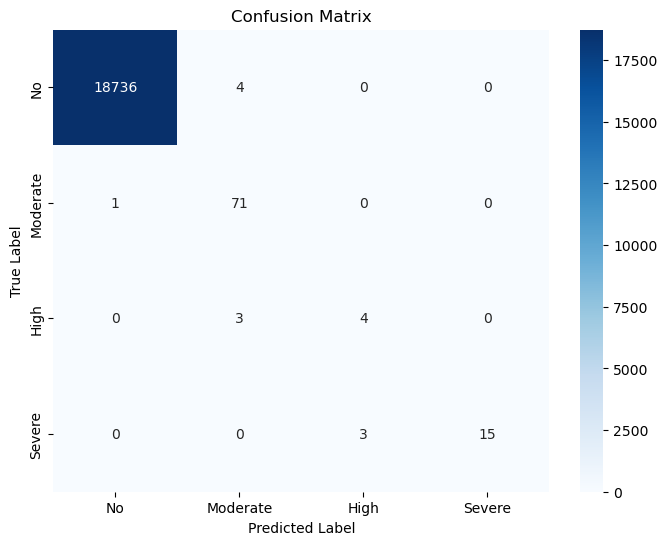

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 11.1: Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 11.2: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Top 10 Most Important Features:
                                    Feature  Importance
10                               cases_lag0        2374
2                            cases_per_100k        2281
11                               cases_lag1        1419
3                                       vim        1315
9                              humidity_avg        1216
8                                  temp_avg        1026
4                                  week_sin         920
12  precipitation_avg_ordinary_kriging_lag3         851
13  precipitation_avg_ordinary_kriging_lag4         850
5                                  week_cos         823


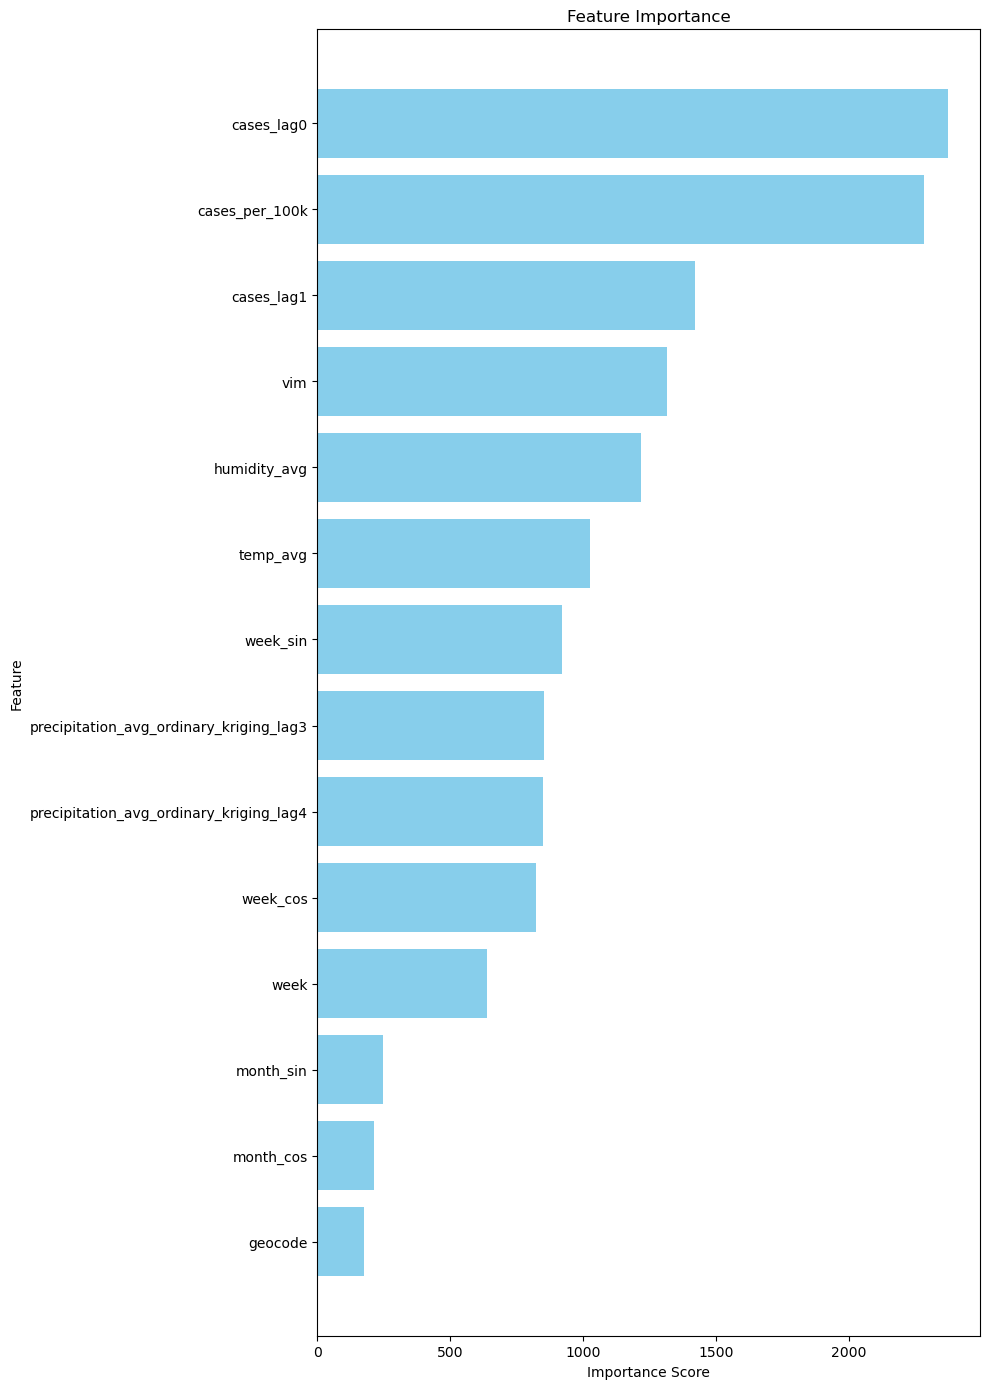

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()

Accuracy: 0.9994
Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00     18740
    Moderate       0.91      0.99      0.95        72
        High       0.57      0.57      0.57         7
      Severe       1.00      0.83      0.91        18

    accuracy                           1.00     18837
   macro avg       0.87      0.85      0.86     18837
weighted avg       1.00      1.00      1.00     18837

Confusion Matrix:
[[18736     4     0     0]
 [    1    71     0     0]
 [    0     3     4     0]
 [    0     0     3    15]]


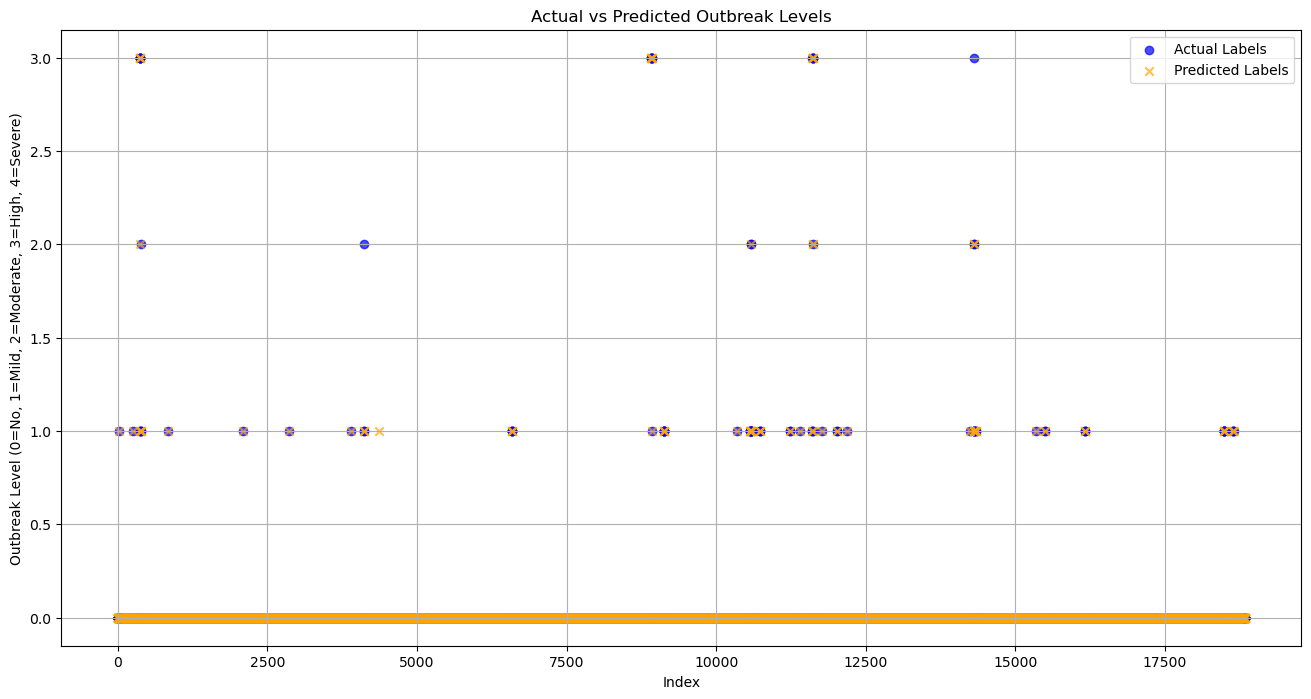

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Evaluate the classification performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Step 3: Plot Actual vs Predicted Labels
plt.figure(figsize=(16, 8))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual Labels', color='blue', alpha=0.7, marker='o')
plt.scatter(np.arange(len(y_pred)), y_pred, label='Predicted Labels', color='orange', alpha=0.7, marker='x')

plt.xlabel('Index')
plt.ylabel('Outbreak Level (0=No, 1=Mild, 2=Moderate, 3=High, 4=Severe)')
plt.title('Actual vs Predicted Outbreak Levels')
plt.legend()
plt.grid(True)
plt.show()


Geocode: 3300100, Accuracy: 1.0000
Unique classes for 3300100: [0 1]
Classification Report for 3300100:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3300100:
[[206   0]
 [  0   1]]


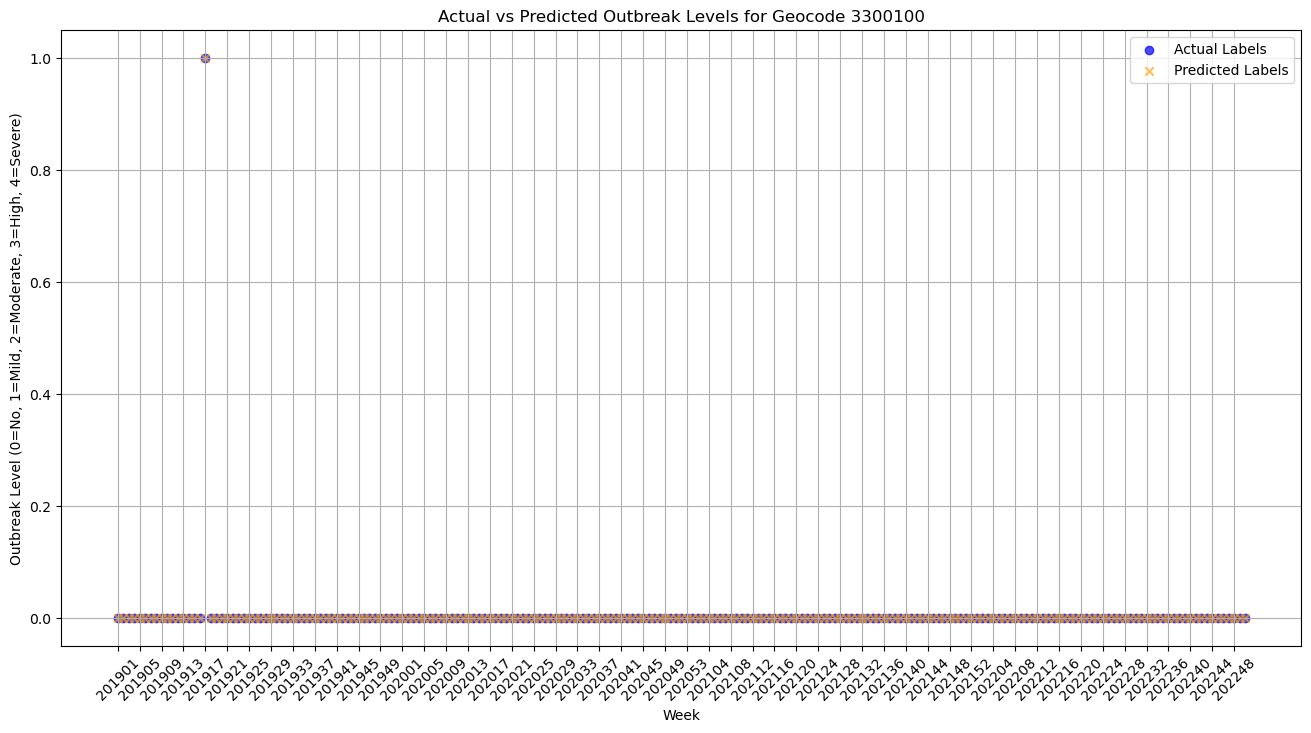

Geocode: 3300159, Accuracy: 0.9903
Unique classes for 3300159: [0 1 2 3]
Classification Report for 3300159:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       195
    Moderate       0.83      1.00      0.91         5
        High       0.00      0.00      0.00         1
      Severe       1.00      0.83      0.91         6

    accuracy                           0.99       207
   macro avg       0.71      0.71      0.70       207
weighted avg       0.99      0.99      0.99       207

Confusion Matrix for 3300159:
[[195   0   0   0]
 [  0   5   0   0]
 [  0   1   0   0]
 [  0   0   1   5]]


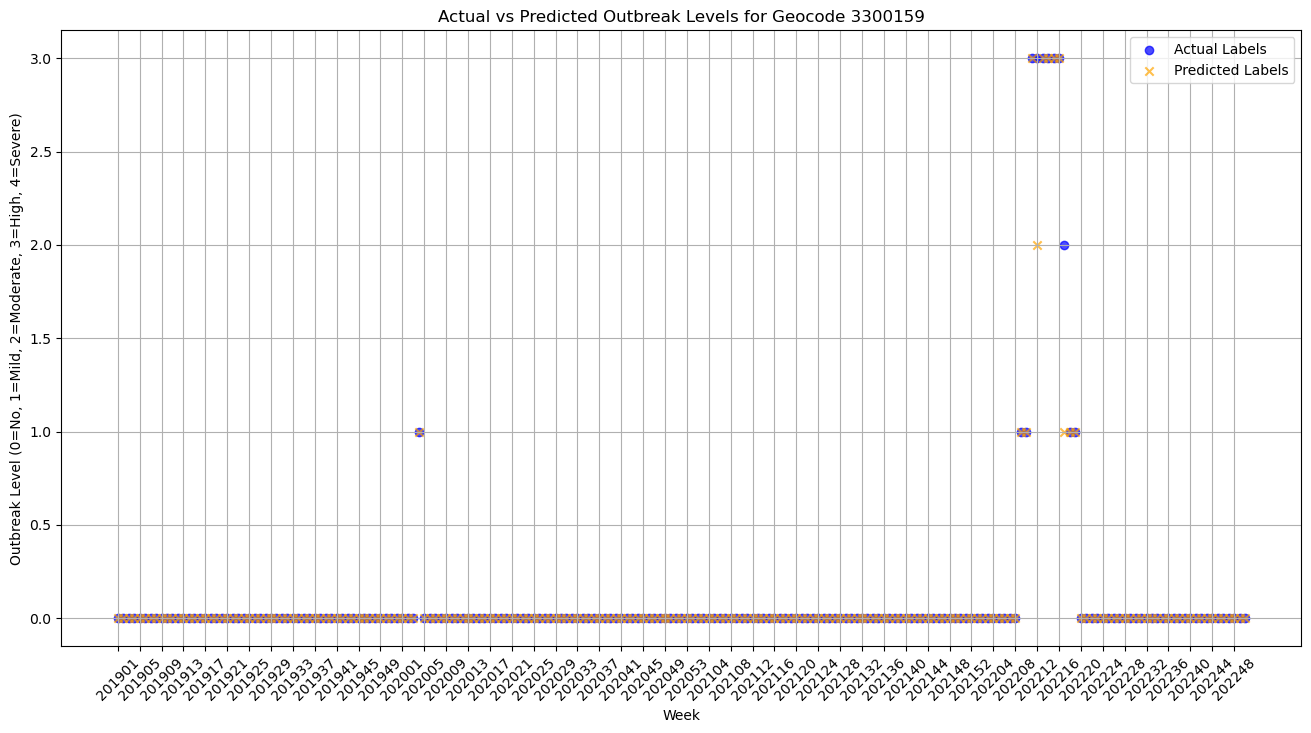

Geocode: 3300233, Accuracy: 1.0000
Unique classes for 3300233: [0 1]
Classification Report for 3300233:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3300233:
[[206   0]
 [  0   1]]


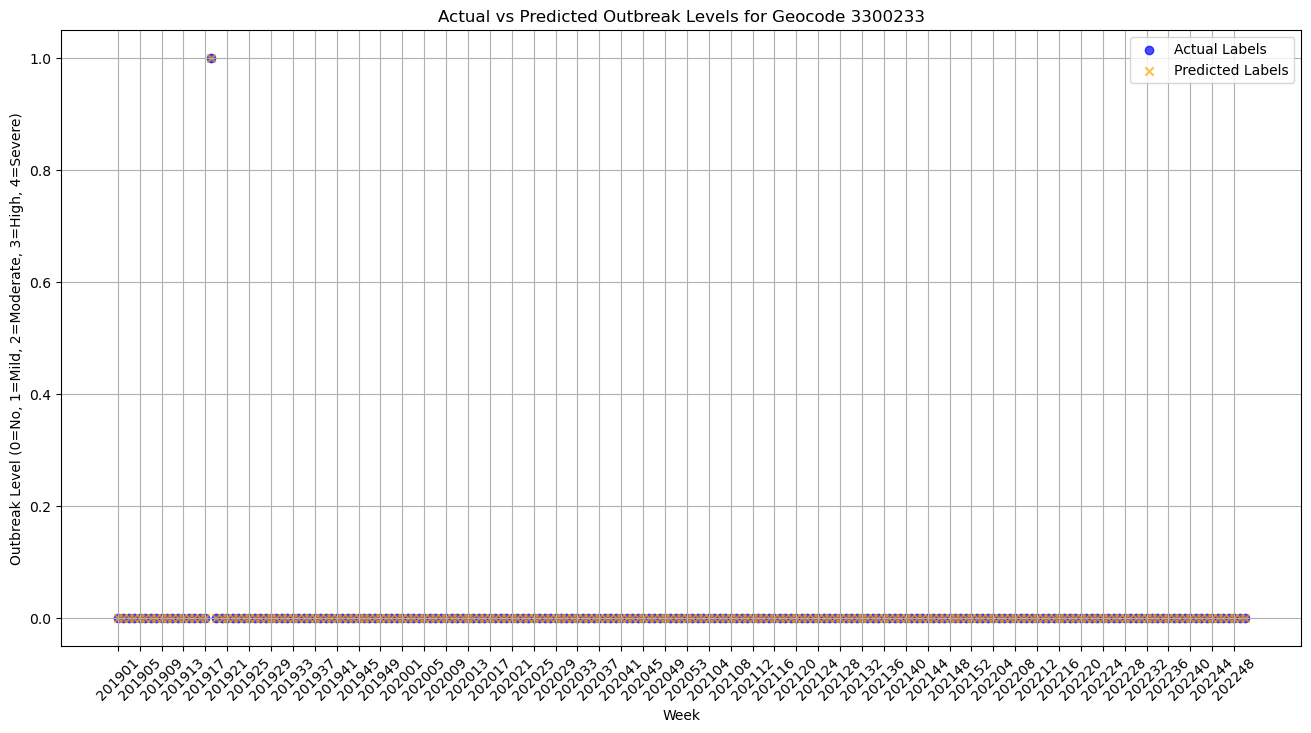

Geocode: 3300605, Accuracy: 1.0000
Unique classes for 3300605: [0 1]
Classification Report for 3300605:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3300605:
[[206   0]
 [  0   1]]


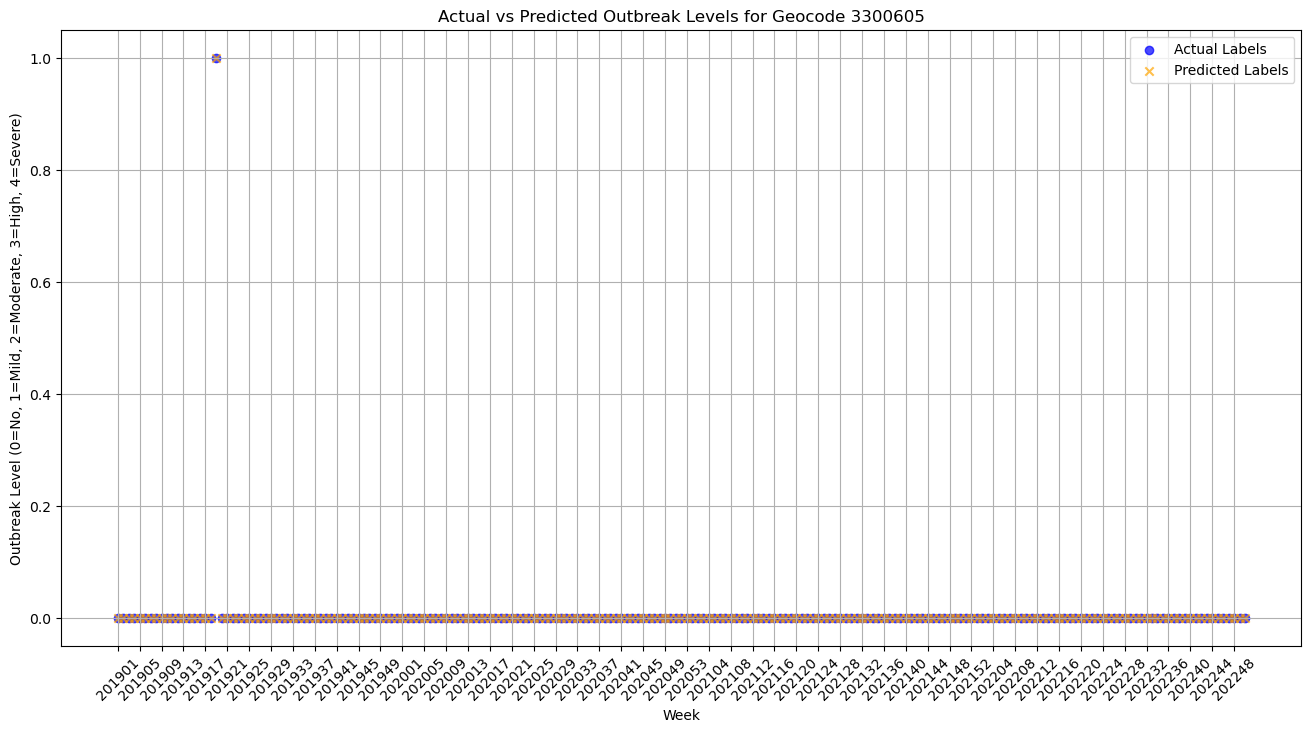

Geocode: 3300902, Accuracy: 1.0000
Unique classes for 3300902: [0 1]
Classification Report for 3300902:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3300902:
[[206   0]
 [  0   1]]


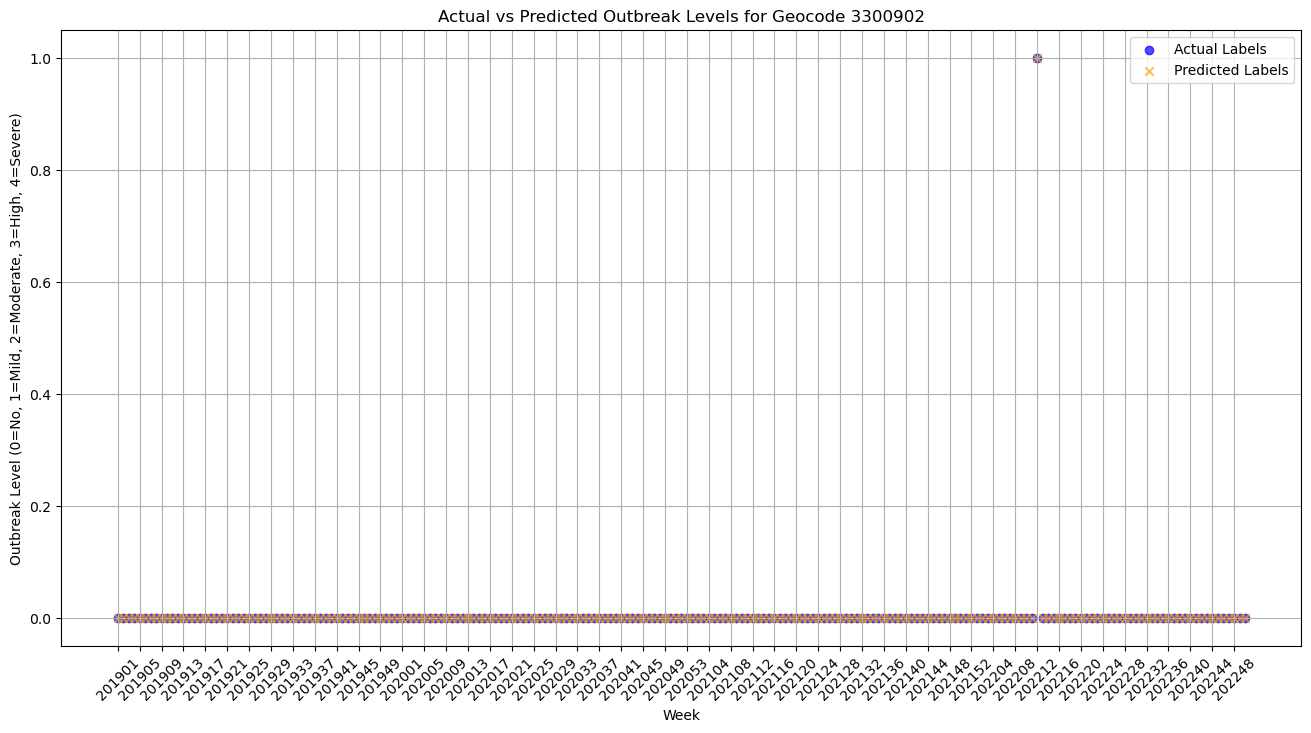

Geocode: 3301157, Accuracy: 1.0000
Unique classes for 3301157: [0 1]
Classification Report for 3301157:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3301157:
[[206   0]
 [  0   1]]


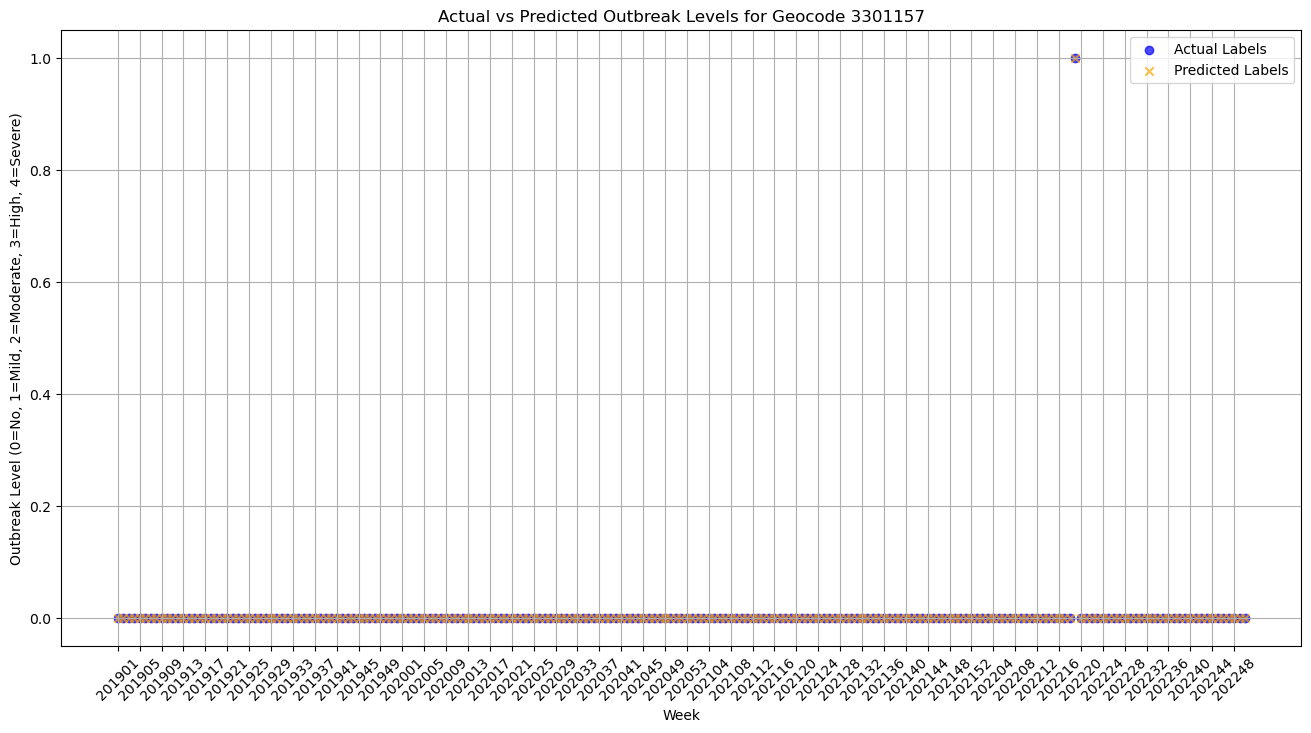

Geocode: 3301207, Accuracy: 0.9952
Unique classes for 3301207: [0 1 2]
Classification Report for 3301207:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       204
    Moderate       0.67      1.00      0.80         2
        High       0.00      0.00      0.00         1

    accuracy                           1.00       207
   macro avg       0.56      0.67      0.60       207
weighted avg       0.99      1.00      0.99       207

Confusion Matrix for 3301207:
[[204   0   0]
 [  0   2   0]
 [  0   1   0]]


C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


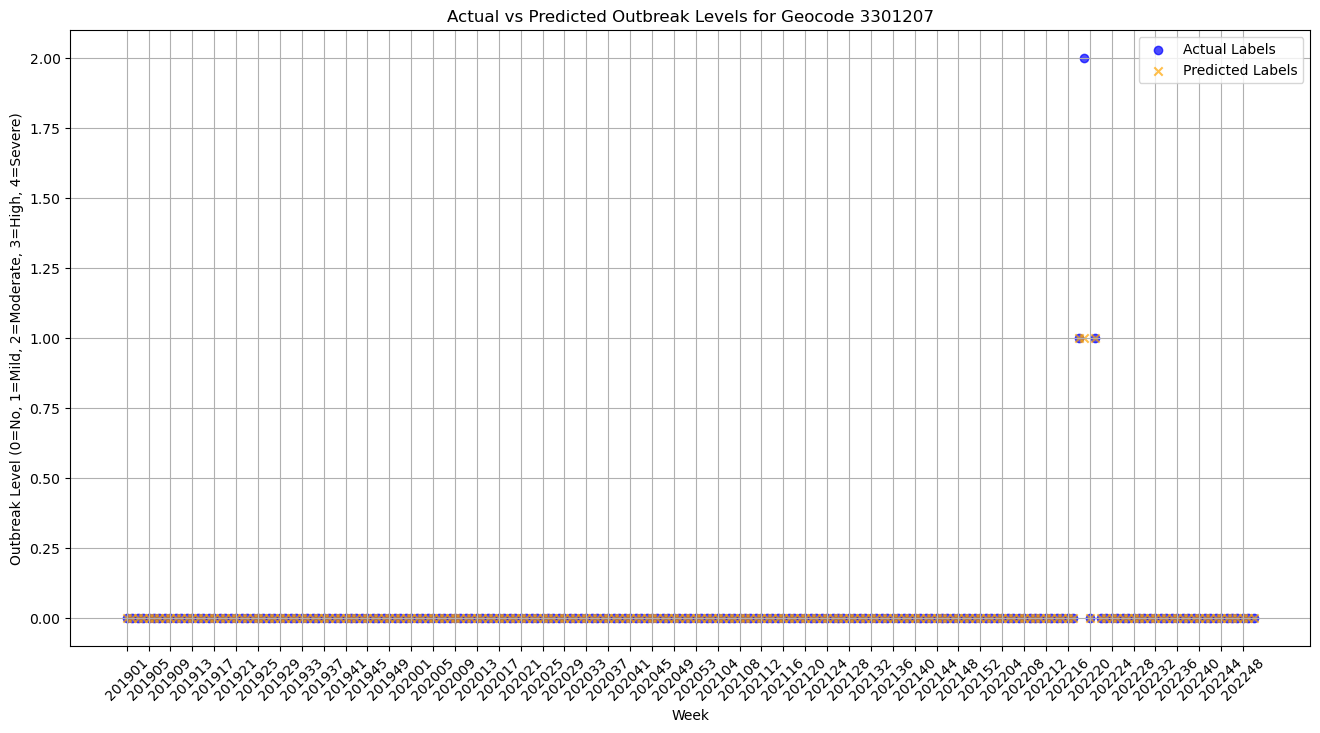

Geocode: 3302106, Accuracy: 0.9952
Unique classes for 3302106: [0 1]
Classification Report for 3302106:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       203
    Moderate       0.80      1.00      0.89         4

    accuracy                           1.00       207
   macro avg       0.90      1.00      0.94       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3302106:
[[202   1]
 [  0   4]]


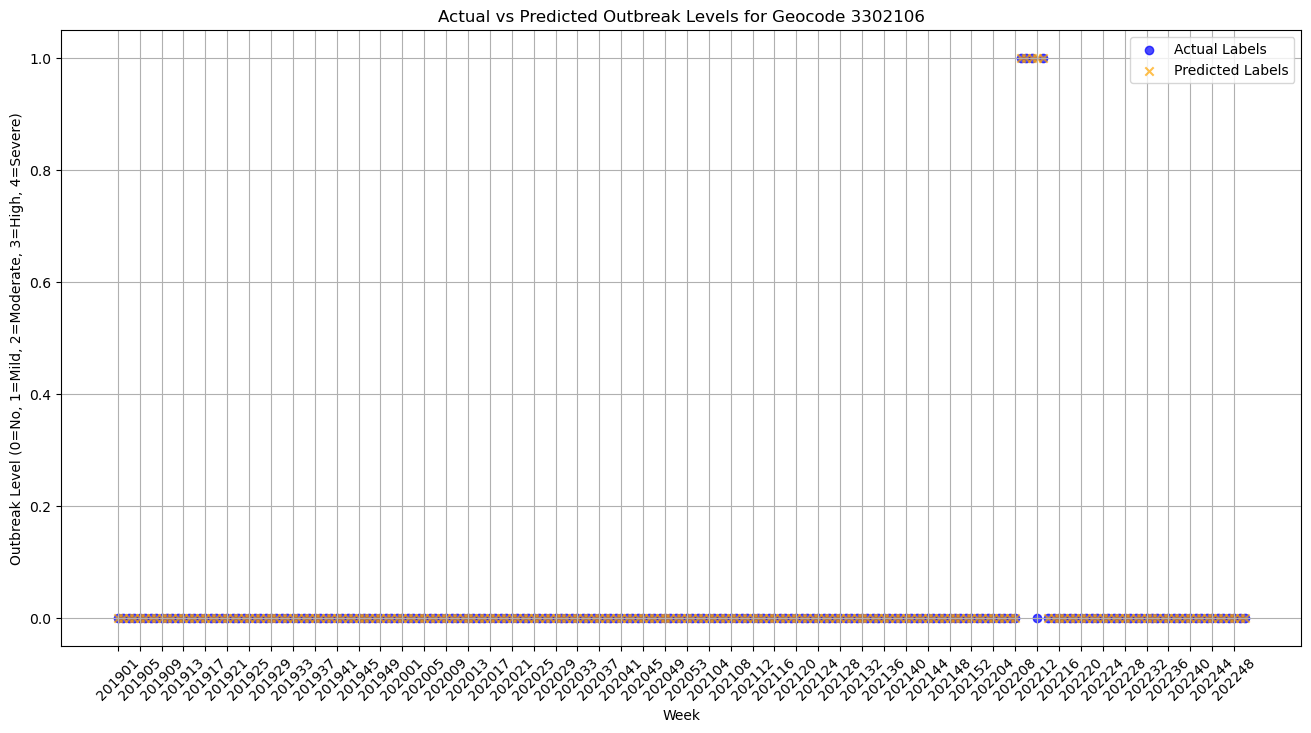

Geocode: 3303005, Accuracy: 1.0000
Unique classes for 3303005: [0 1 3]
Classification Report for 3303005:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       200
    Moderate       1.00      1.00      1.00         1
        High       1.00      1.00      1.00         6

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3303005:
[[200   0   0]
 [  0   1   0]
 [  0   0   6]]


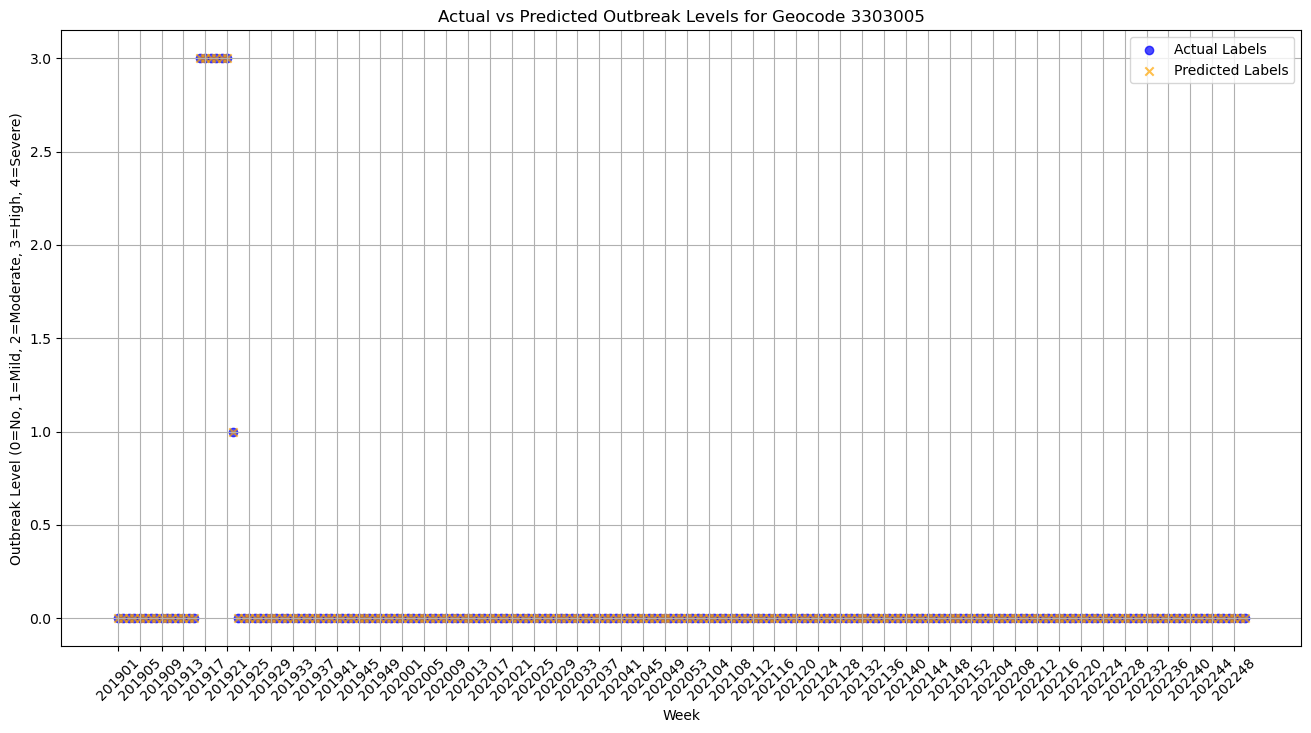

Geocode: 3303104, Accuracy: 0.9952
Unique classes for 3303104: [0 1]
Classification Report for 3303104:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       201
    Moderate       1.00      0.83      0.91         6

    accuracy                           1.00       207
   macro avg       1.00      0.92      0.95       207
weighted avg       1.00      1.00      0.99       207

Confusion Matrix for 3303104:
[[201   0]
 [  1   5]]


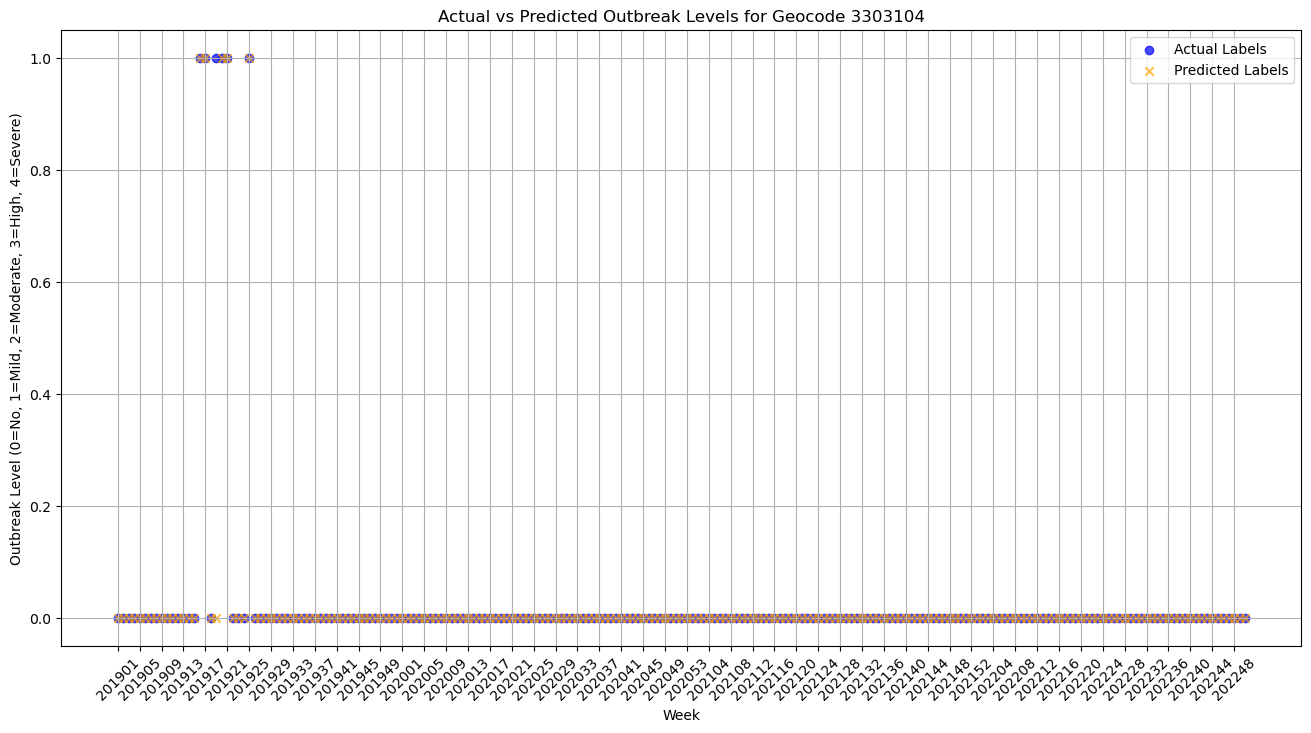

Geocode: 3303708, Accuracy: 1.0000
Unique classes for 3303708: [0 1]
Classification Report for 3303708:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3303708:
[[206   0]
 [  0   1]]


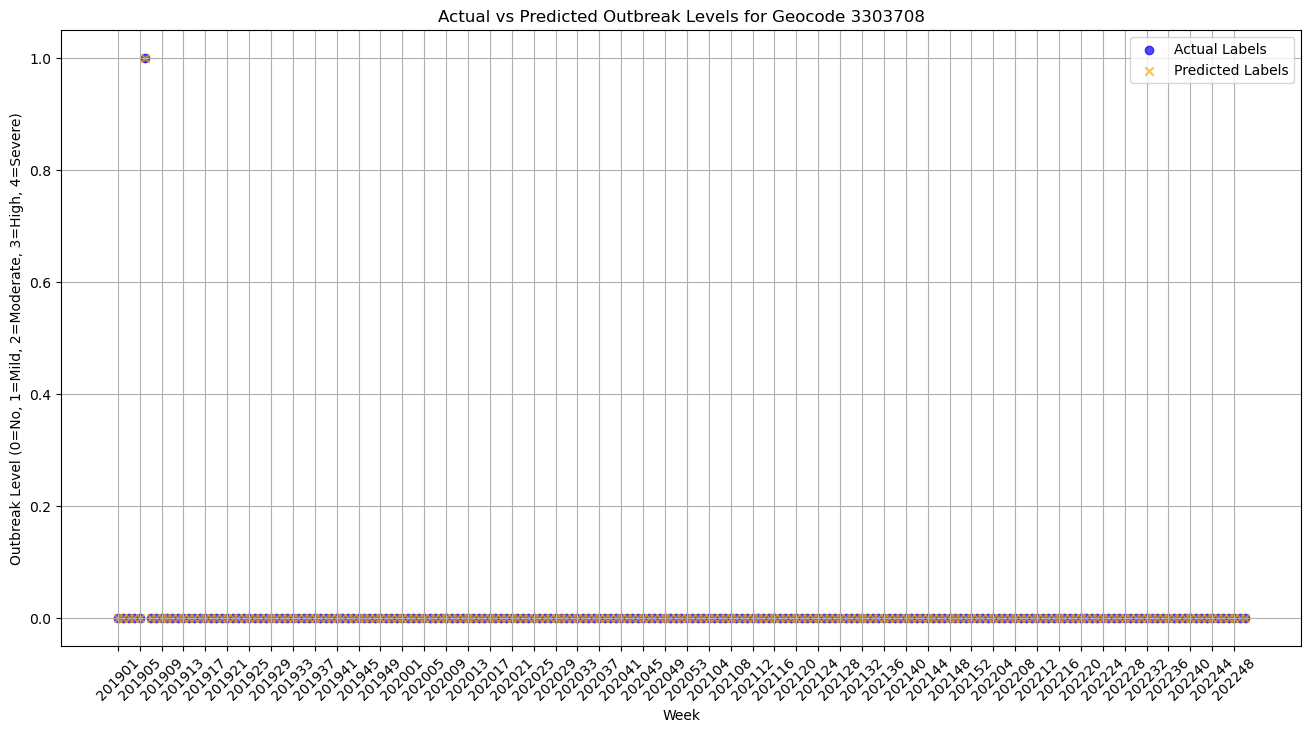

Geocode: 3303807, Accuracy: 0.9903
Unique classes for 3303807: [0 1 2]
Classification Report for 3303807:
              precision    recall  f1-score   support

          No       1.00      0.99      1.00       191
    Moderate       0.88      1.00      0.93        14
        High       1.00      0.50      0.67         2

    accuracy                           0.99       207
   macro avg       0.96      0.83      0.87       207
weighted avg       0.99      0.99      0.99       207

Confusion Matrix for 3303807:
[[190   1   0]
 [  0  14   0]
 [  0   1   1]]


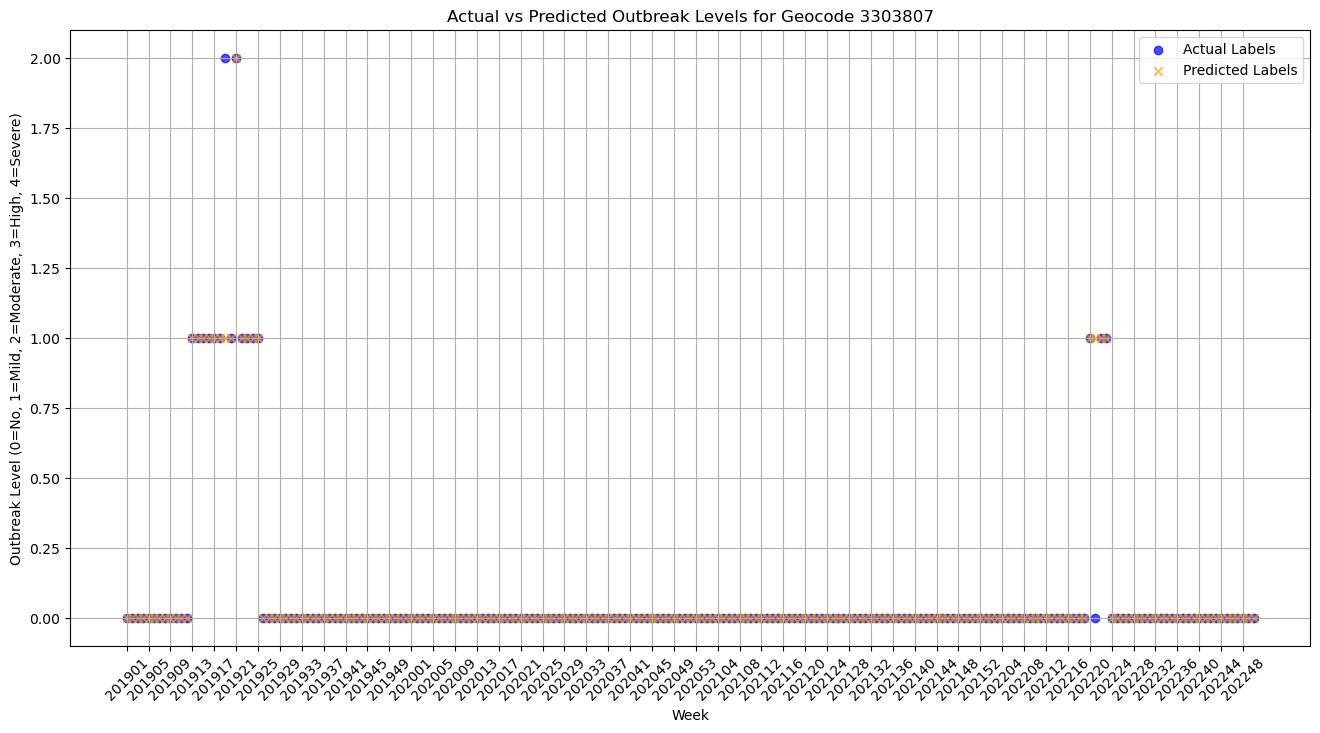

Geocode: 3303955, Accuracy: 1.0000
Unique classes for 3303955: [0 1]
Classification Report for 3303955:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       205
    Moderate       1.00      1.00      1.00         2

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3303955:
[[205   0]
 [  0   2]]


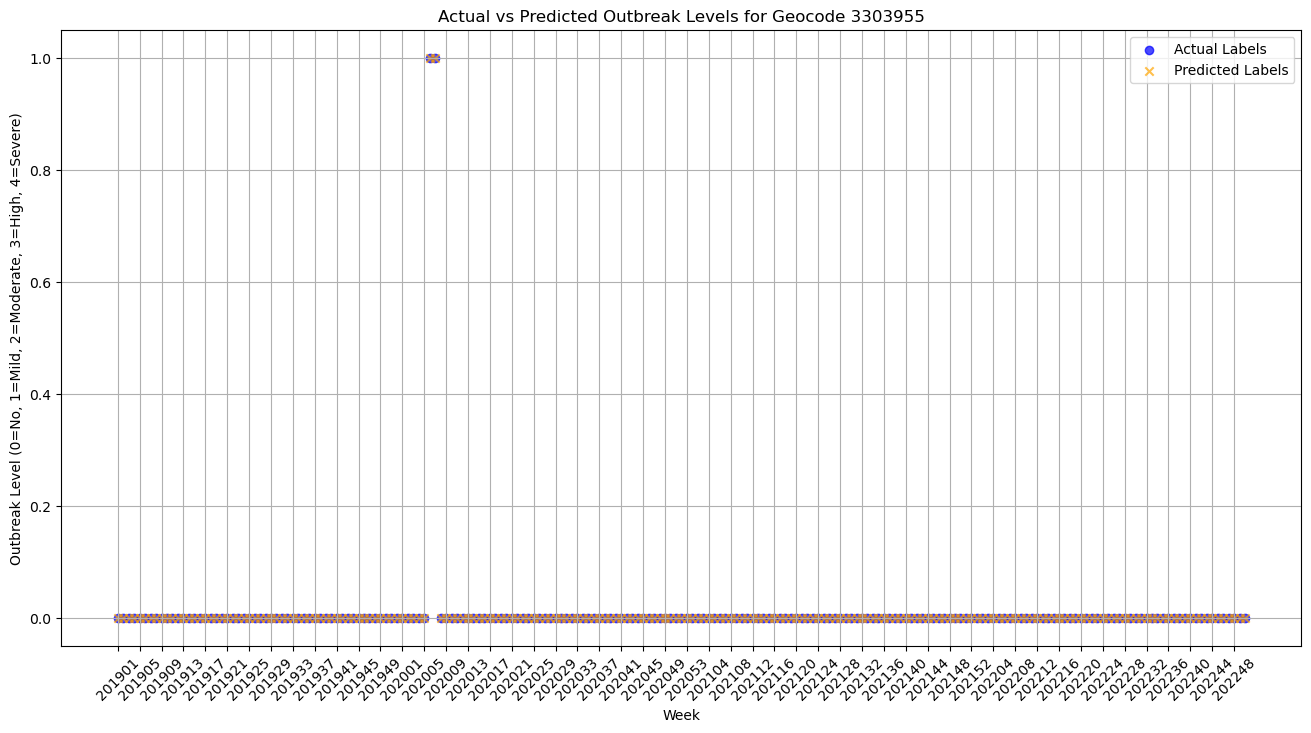

Geocode: 3304003, Accuracy: 1.0000
Unique classes for 3304003: [0 1]
Classification Report for 3304003:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3304003:
[[206   0]
 [  0   1]]


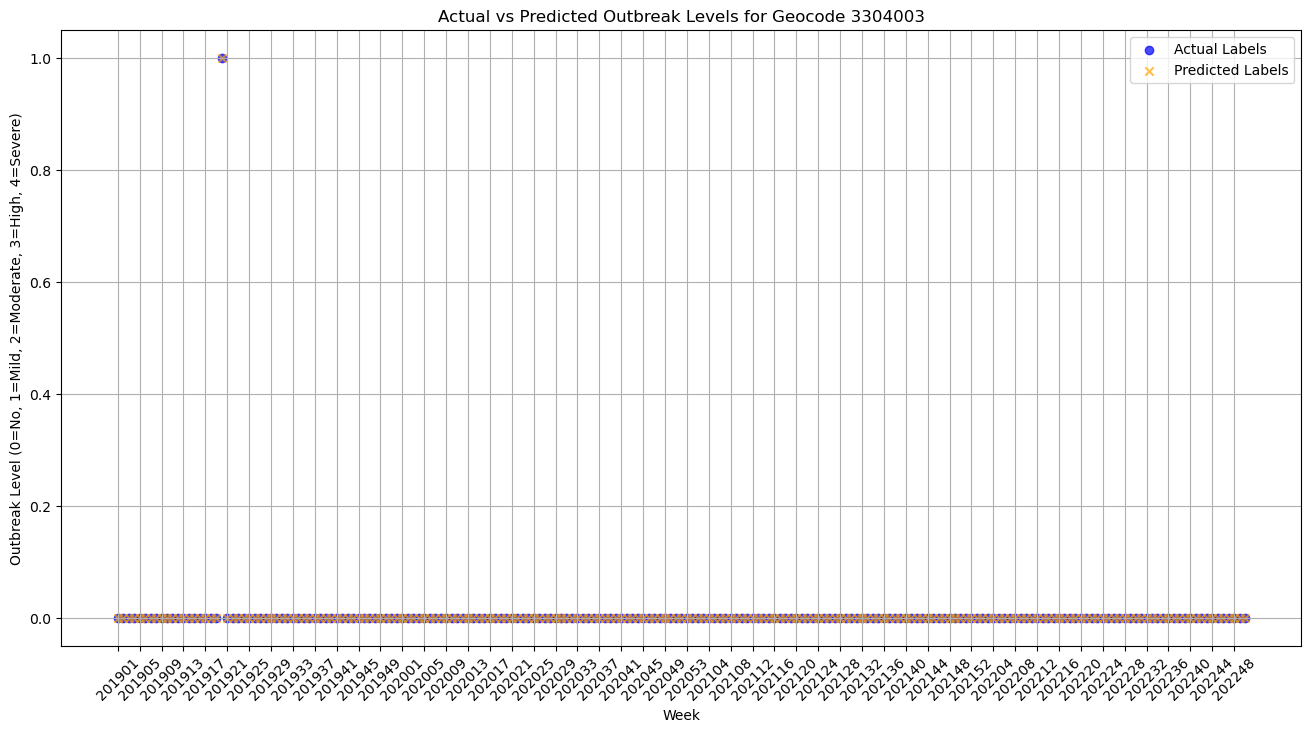

Geocode: 3304102, Accuracy: 0.9952
Unique classes for 3304102: [0 1 2 3]
Classification Report for 3304102:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       197
    Moderate       1.00      1.00      1.00         4
        High       0.50      1.00      0.67         1
      Severe       1.00      0.80      0.89         5

    accuracy                           1.00       207
   macro avg       0.88      0.95      0.89       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3304102:
[[197   0   0   0]
 [  0   4   0   0]
 [  0   0   1   0]
 [  0   0   1   4]]


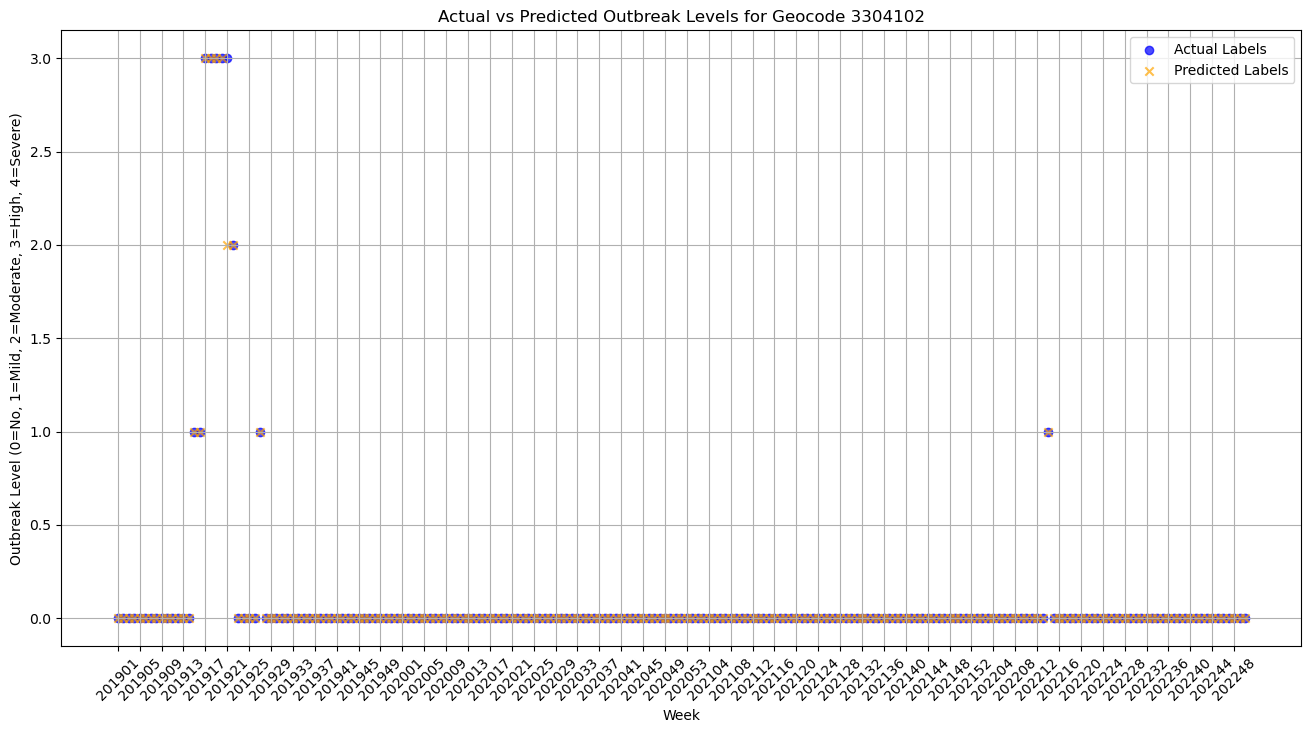

Geocode: 3304128, Accuracy: 1.0000
Unique classes for 3304128: [0 1]
Classification Report for 3304128:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       204
    Moderate       1.00      1.00      1.00         3

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3304128:
[[204   0]
 [  0   3]]


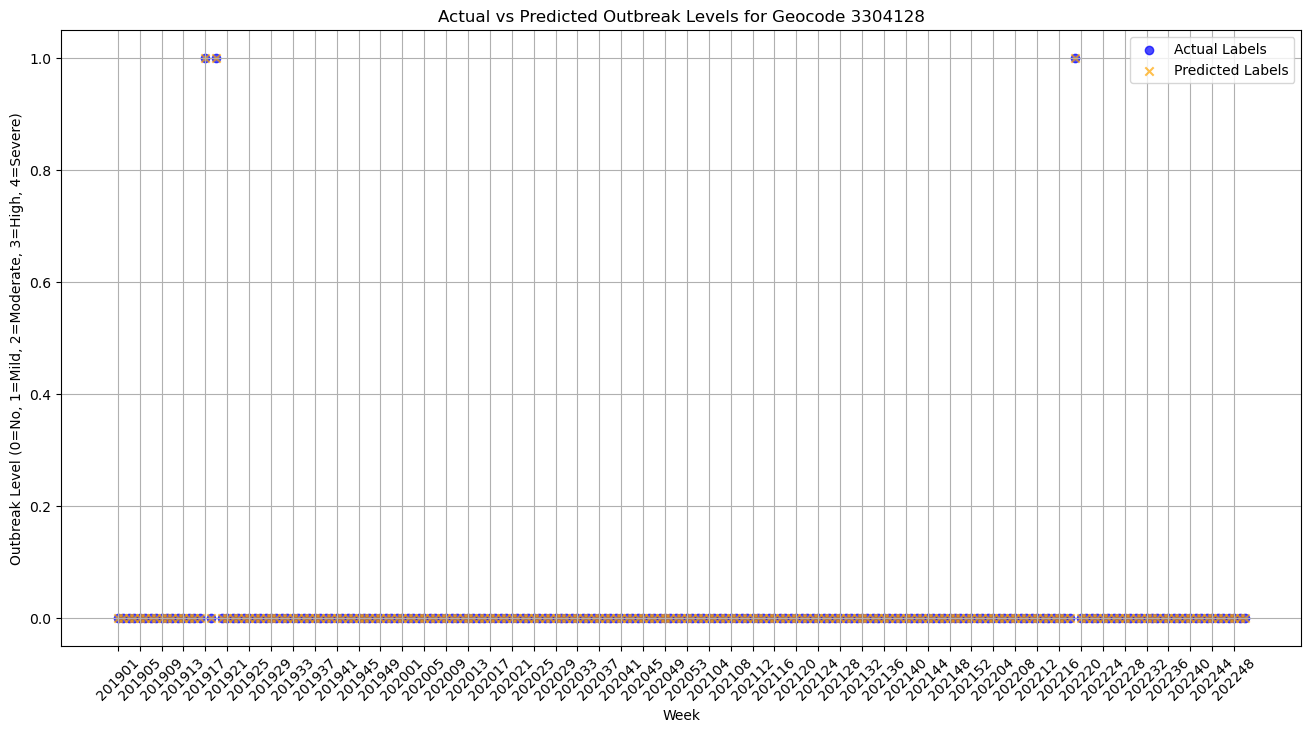

Geocode: 3304706, Accuracy: 1.0000
Unique classes for 3304706: [0 1]
Classification Report for 3304706:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       206
    Moderate       1.00      1.00      1.00         1

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3304706:
[[206   0]
 [  0   1]]


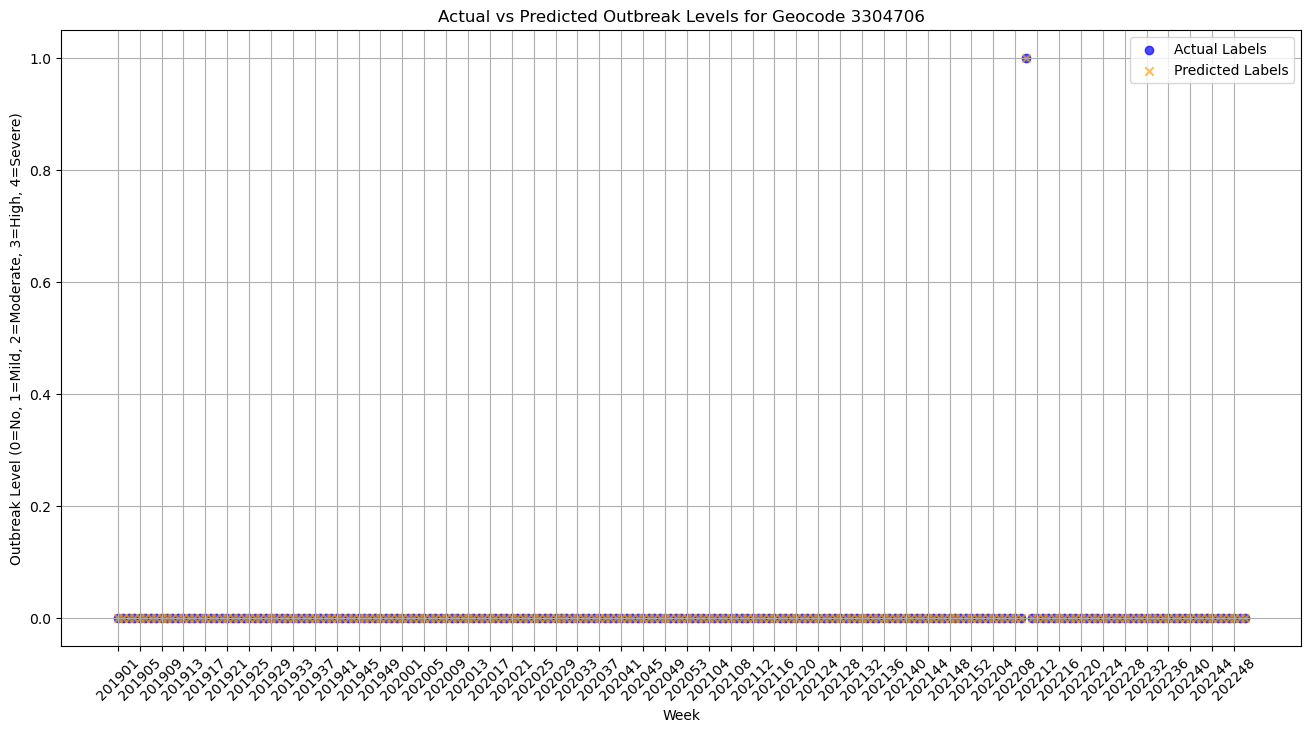

Geocode: 3304755, Accuracy: 0.9903
Unique classes for 3304755: [0 1 2 3]
Classification Report for 3304755:
              precision    recall  f1-score   support

          No       1.00      0.99      1.00       197
    Moderate       0.88      1.00      0.93         7
        High       0.67      1.00      0.80         2
      Severe       0.00      0.00      0.00         1

    accuracy                           0.99       207
   macro avg       0.64      0.75      0.68       207
weighted avg       0.99      0.99      0.99       207

Confusion Matrix for 3304755:
[[196   1   0   0]
 [  0   7   0   0]
 [  0   0   2   0]
 [  0   0   1   0]]


C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


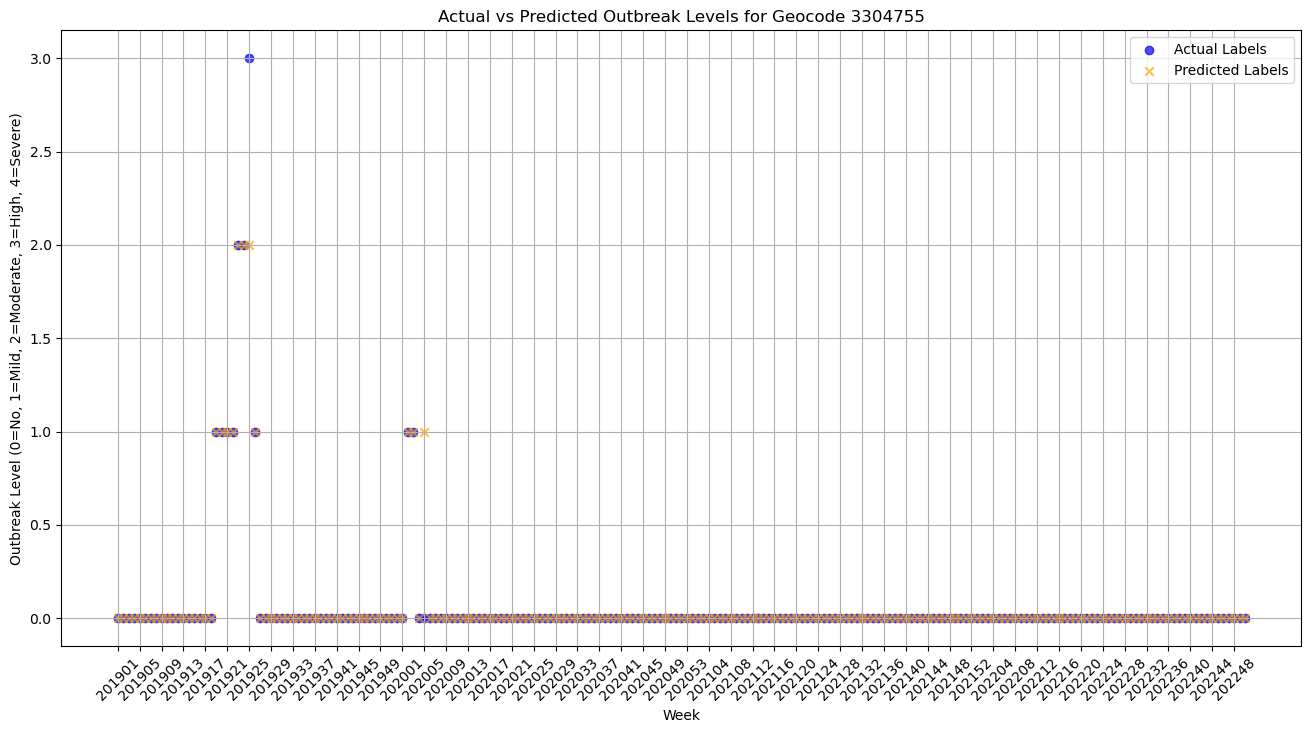

Geocode: 3305133, Accuracy: 1.0000
Unique classes for 3305133: [0 1]
Classification Report for 3305133:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       204
    Moderate       1.00      1.00      1.00         3

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3305133:
[[204   0]
 [  0   3]]


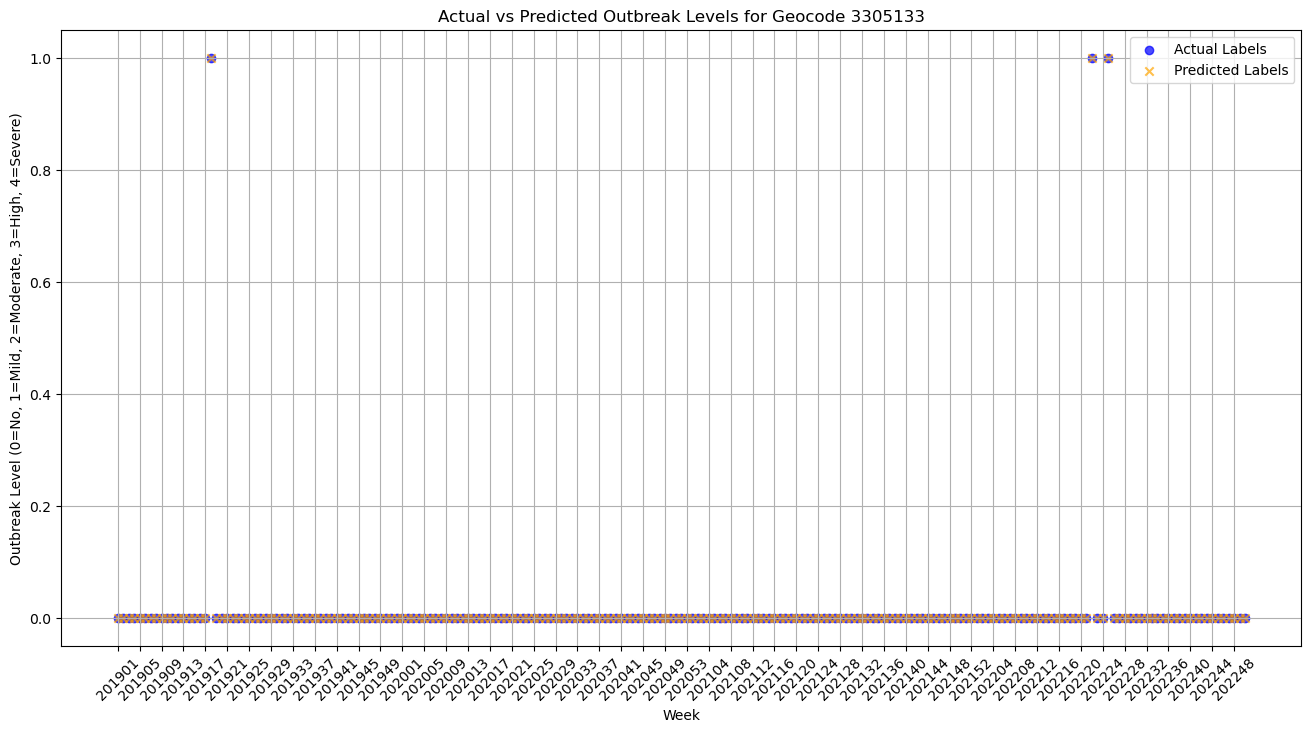

Geocode: 3305406, Accuracy: 1.0000
Unique classes for 3305406: [0 1]
Classification Report for 3305406:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       204
    Moderate       1.00      1.00      1.00         3

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3305406:
[[204   0]
 [  0   3]]


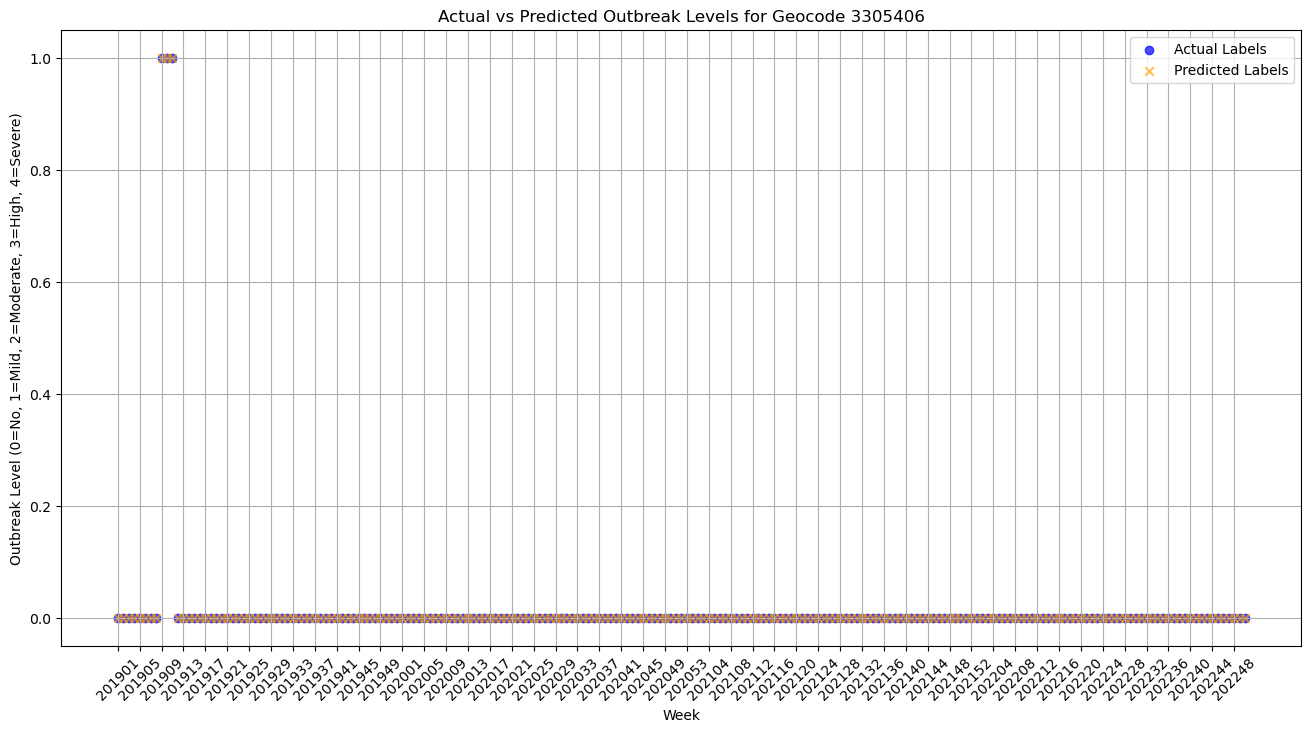

Geocode: 3306206, Accuracy: 1.0000
Unique classes for 3306206: [0 1]
Classification Report for 3306206:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       201
    Moderate       1.00      1.00      1.00         6

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3306206:
[[201   0]
 [  0   6]]


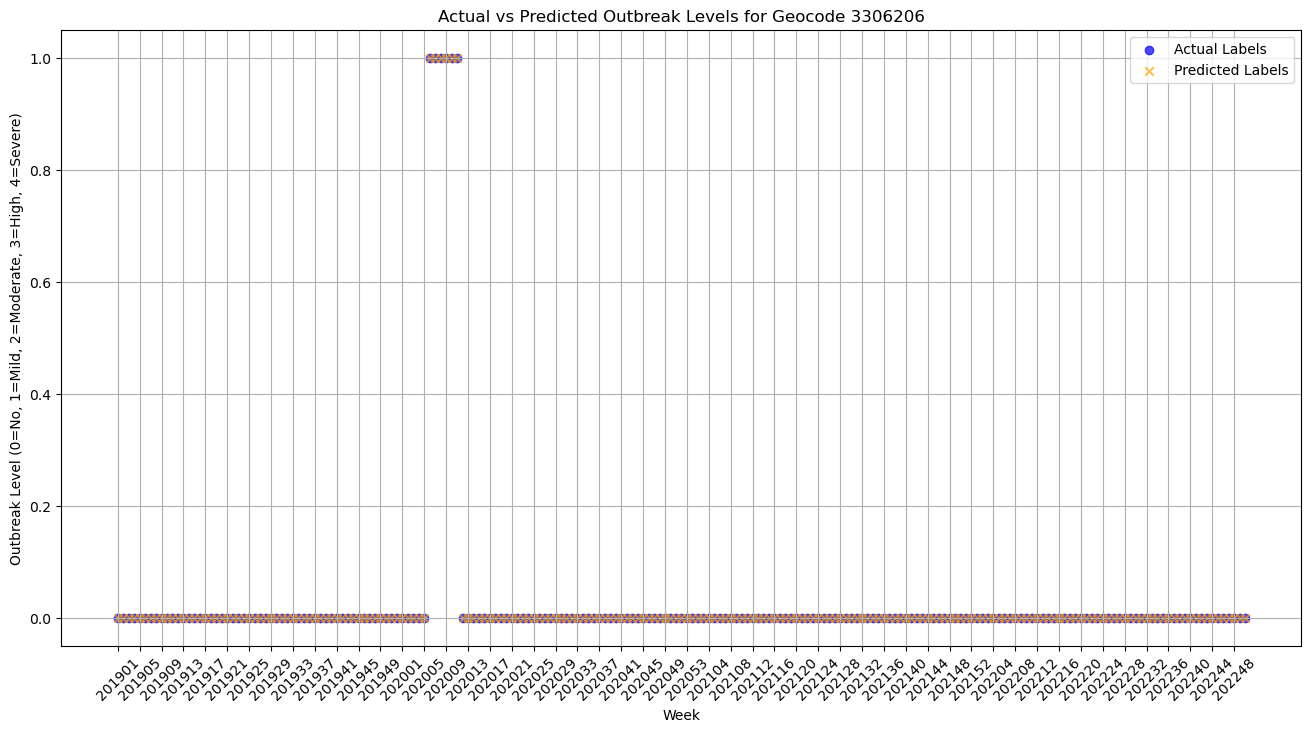

Geocode: 3306305, Accuracy: 1.0000
Unique classes for 3306305: [0 1]
Classification Report for 3306305:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       203
    Moderate       1.00      1.00      1.00         4

    accuracy                           1.00       207
   macro avg       1.00      1.00      1.00       207
weighted avg       1.00      1.00      1.00       207

Confusion Matrix for 3306305:
[[203   0]
 [  0   4]]


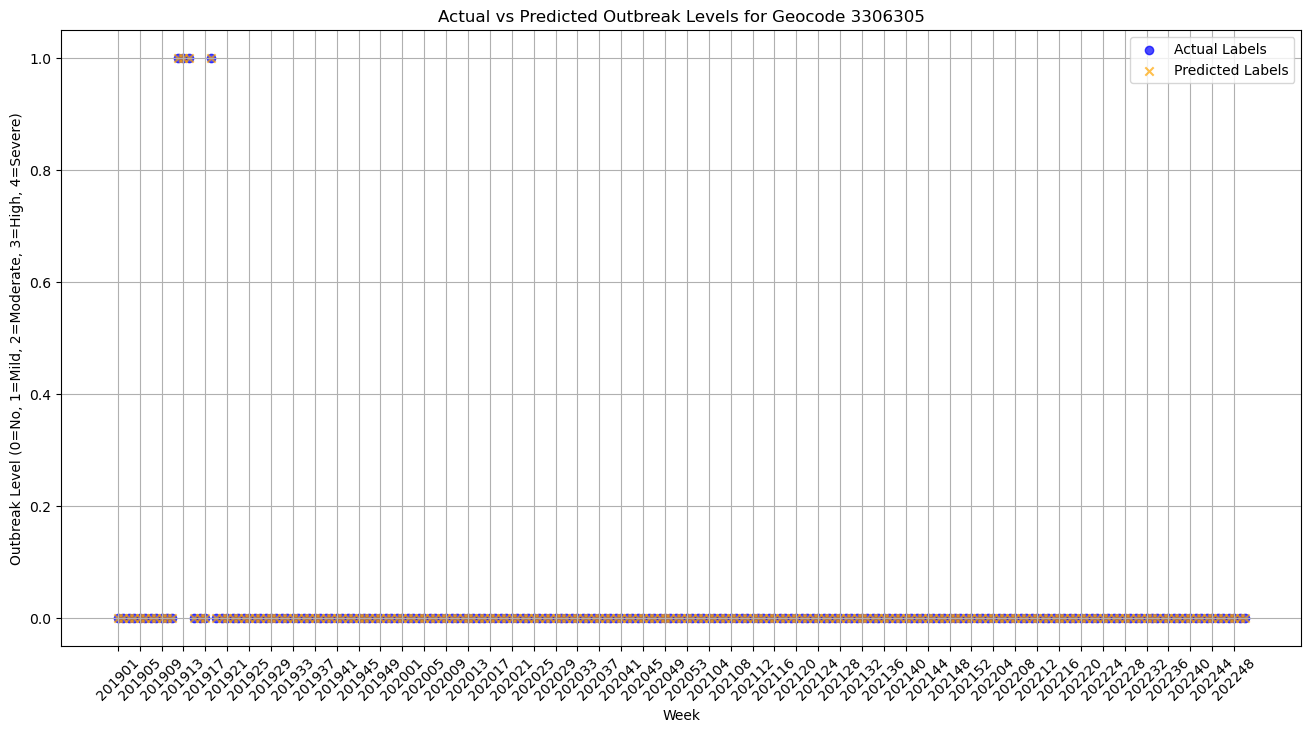

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'geocode' and 'week' are present in X_test
geocodes = X_test['geocode'].unique()

for geo in geocodes:
    # Filter data for the geocode
    geo_indices = X_test['geocode'] == geo
    y_actual_geo = y_test[geo_indices]
    y_pred_geo = y_pred[geo_indices]
    weeks_geo = X_test['week'][geo_indices].astype(str)

    # Skip the geocode if the maximum actual outbreak level is less than 1 (i.e., No outbreak)
    if np.max(y_actual_geo) < 1:
        continue

    # Compute accuracy for the geocode
    accuracy_geo = accuracy_score(y_actual_geo, y_pred_geo)
    print(f'Geocode: {geo}, Accuracy: {accuracy_geo:.4f}')

    # Check unique classes in actual and predicted values
    unique_classes = np.unique(y_actual_geo)
    print(f'Unique classes for {geo}: {unique_classes}')

    # Define target names based on unique classes
    target_names = labels
    if len(unique_classes) < len(target_names):
        target_names = target_names[:len(unique_classes)]

    # Classification report
    print(f"Classification Report for {geo}:")
    print(classification_report(y_actual_geo, y_pred_geo, target_names=target_names))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_actual_geo, y_pred_geo)
    print(f"Confusion Matrix for {geo}:")
    print(conf_matrix)

    # Plot for the geocode with weeks on the x-axis
    plt.figure(figsize=(16, 8))
    plt.scatter(weeks_geo, y_actual_geo, label='Actual Labels', color='blue', alpha=0.7, marker='o')
    plt.scatter(weeks_geo, y_pred_geo, label='Predicted Labels', color='orange', alpha=0.7, marker='x')
    plt.xlabel('Week')
    plt.ylabel('Outbreak Level (0=No, 1=Mild, 2=Moderate, 3=High, 4=Severe)')
    plt.title(f'Actual vs Predicted Outbreak Levels for Geocode {geo}')
    plt.legend()
    plt.grid(True)

    # Select every 4th week for x-axis labels
    ticks = weeks_geo[::4]
    plt.xticks(ticks, rotation=45)
    plt.show()
